In [1]:
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pennylane as qml
import torch
from torch import nn
from torch.utils.data import TensorDataset, Dataset, DataLoader
import numpy as np

#### Human Activity Recognition Using Smartphones Data Set

- ***Fuente original:***
UCI Machine Learning Repository
https://archive.ics.uci.edu/ml/datasets/human+activity+recognition+using+smartphones

- ***Objetivo:***
Clasificar la actividad física realizada por una persona con base en sensores del smartphone.


- ***Variable objetivo (target)→ actividad humana***
WALKING, WALKING_UPSTAIRS, WALKING_DOWNSTAIRS, SITTING, STANDING, LAYING

In [2]:
# Cargar el dataset HAR desde OpenML
har_data = fetch_openml(data_id=1478, as_frame=True)
df = har_data.frame
df.columns

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       ...
       'V553', 'V554', 'V555', 'V556', 'V557', 'V558', 'V559', 'V560', 'V561',
       'Class'],
      dtype='object', length=562)

#### Clases:'WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING'

In [3]:
# Separar features y etiquetas
X = df.drop("Class", axis=1)
y = df["Class"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Usamos PCA con 10 componentes
pca = PCA(n_components=15)
X_pca = pca.fit_transform(X_scaled)

# Para reducir el dataset a un tamaño manejable (ejemplo con 200 muestras)
X_small = X_pca[:100]
y_small = y[:100]

# Codificamos las etiquetas para cross-entropy
y_encoded = torch.tensor(np.array([np.where(np.unique(y_small) == label)[0][0] for label in y_small]), dtype=torch.long)


In [4]:
# Convertimos a tensores de PyTorch
X_tensor = torch.tensor(X_small, dtype=torch.float32)
y_tensor = torch.tensor(y_encoded, dtype=torch.long)

# Barajamos y separamos en train/test
X_tensor, y_tensor = shuffle(X_tensor, y_tensor, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(
    X_tensor, y_tensor, test_size=0.2, random_state=42
)
X_train.shape, y_train.shape

/var/folders/nv/2vg5q8t90j16svvsqd8ln3v00000gn/T/ipykernel_41317/1797263790.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.tensor(y_encoded, dtype=torch.long)


(torch.Size([80, 15]), torch.Size([80]))

In [5]:
bs=32
train_ds = TensorDataset(X_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)
test_ds = TensorDataset(X_test, y_test)
test_dl = DataLoader(test_ds, batch_size=bs, shuffle=True)

### Creacion del circuito cuantico 

In [6]:
def QCircuit(n_layers, n_qubits, n_outputs):
    dev= qml.device("default.qubit", wires=n_qubits)
    paramShapes= {'weights': (n_layers, n_qubits, 4), 'weightsin': (n_layers, n_qubits, 1)}
    
    @qml.qnode(dev)
    #def circuit(inputs, weights):  
    def circuit(inputs, weights, weightsin):  
        for l in range(n_layers):
            # Input embedding
            for q in range(n_qubits):
                qml.RY(inputs[q]*(weightsin[l, q, 0]), wires=q) #Parece que tiene mucho overfitting
            # Capa de variational gates con parámetros aprendibles
            
            for i in range(n_qubits):
                qml.RX(weights[l, i, 0], wires=i)
                qml.RY(weights[l, i, 1], wires=i)
                qml.RZ(weights[l, i, 2], wires=i)
                #qml.U3(weights[l, i, 0], weights[l, i, 1], weights[l, i, 2], wires=i)
            for i in range(n_qubits):    
                for j in range(i + 1, n_qubits):
                    qml.CRY(weights[l, i, 3], wires=[i, j])

            # Entrelazamiento tipo entanglement en anillo
            for i in range(n_qubits):
                qml.CNOT(wires=[i, (i + 1) % n_qubits])
            # Full entanglement
            #for i in range(n_qubits):
            #    for j in range(i+1, n_qubits):
            #        qml.CNOT(wires=[i, j])
            
        # Measurement
        return [qml.expval(qml.PauliZ(q)) for q in range(n_outputs)] #medicion local
        #return qml.expval(qml.PauliZ(0)), qml.expval(qml.PauliZ(1)) #medicion global
    
    #model = qml.qnn.TorchLayer(circuit, paramShapes, init_method = torch.nn.init.uniform_)
    model = qml.qnn.TorchLayer(circuit, paramShapes)

    return model

In [7]:
class VQC(nn.Module):
    
    # preprocessing: nn.Module para hacer un preprocesamiento a los datos
    # circuit: Circuito cuántico a usar (tipo qml.qnn.TorchLayer)
    # n_qubits: Número de qubits del circuito
    # n_outputs: Los n_outputs primeros qubits del circuito serán salidas
    # n_layers: Número de capas a replicar el circuito
    # postprocessing: nn.Module para hacer un postprocesamiento a los datos de salida del circuito
    def __init__(self, preprocessing, circuit, n_qubits, n_outputs, n_layers, postprocessing):
        
        super(VQC, self).__init__()
        
        # Initialize hyperparameters
        self.preprocessing= preprocessing
        self.postprocessing= postprocessing
        self.n_qubits= n_qubits
        self.n_layers= n_layers
        self.n_outputs= n_outputs
        self.qmodel= circuit
        
        
    def nOutputs(self):
        return self.n_outputs


    # Classifier
    def forward(self, inputs):
        if not isinstance(inputs, torch.Tensor):
            inputs= torch.tensor(np.array(inputs))
        
        if self.preprocessing is not None:
            pre= self.preprocessing(inputs)
        else:
            pre= inputs
        #out= self.qmodel(pre)
        out = torch.stack([self.qmodel(x) for x in pre])
        if self.postprocessing is not None:            
            out= self.postprocessing(out)
        return out  

In [8]:
train_loss_history = []
test_loss_history = []
test_acc_history = []
gradient_history = []

In [9]:
# --- Función de entrenamiento ---
def train_model(model, epochs=30, label="baseline"):
    
    #model = QuantumNet()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.0001)
    loss_fn = nn.CrossEntropyLoss()

    global train_loss_history, test_acc_history, gradient_history
    train_loss_history = []
    test_acc_history = []
    gradient_history = []

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        train_batch= iter(train_dl)
        for xb, yb in train_batch:
            output = model(xb)
            #loss = loss_fn(output.squeeze(-1), y_train)
            loss = loss_fn(output, yb)
            loss.backward()
            # === Monitorizar norma media del gradiente ===
            grad_norms = []
            for param in model.parameters():
                if param.grad is not None:
                    grad_norms.append(param.grad.abs().mean().item())
            avg_grad = sum(grad_norms) / len(grad_norms)
            gradient_history.append(avg_grad)
            optimizer.step()

        model.eval()
        with torch.no_grad():
            test_data, test_targets = next(iter(test_dl))
            test_output = model(test_data)
            #test_loss = loss_fn(test_output.squeeze(-1), y_test)
            test_loss = loss_fn(test_output, test_targets)
            acc = (torch.argmax(test_output, dim=1) == test_targets).float().mean()
        train_loss_history.append(loss.item())
        test_loss_history.append(test_loss.item())
        test_acc_history.append(acc.item())
        print(f"Epoch {epoch+1}: Train Loss = {loss.item():.4f} | Test loss = {test_loss.item():.4f} | Test Acc = {acc.item():.4f} | GradNorm = {avg_grad:.6f}")

In [10]:
nInputs= X_train.shape[1]
nOutputs= len(np.unique(y))
num_qubits= nInputs
num_layers = 10  # aumentamos este valor para provocar barren plateau
preprocessing= None
postprocessing= None
circuit= QCircuit(num_layers, num_qubits, nOutputs)
model= VQC(preprocessing, circuit, num_qubits, nOutputs, num_layers, postprocessing)
train_model(model,epochs=10, label="meseta")  

weights initialization
Epoch 1: Train Loss = 1.7909 | Test loss = 1.7928 | Test Acc = 0.1500 | GradNorm = 0.002382
Epoch 2: Train Loss = 1.7919 | Test loss = 1.7928 | Test Acc = 0.1500 | GradNorm = 0.002212
Epoch 3: Train Loss = 1.7923 | Test loss = 1.7928 | Test Acc = 0.1500 | GradNorm = 0.002354
Epoch 4: Train Loss = 1.7907 | Test loss = 1.7928 | Test Acc = 0.1500 | GradNorm = 0.002376
Epoch 5: Train Loss = 1.7915 | Test loss = 1.7928 | Test Acc = 0.1500 | GradNorm = 0.002183
Epoch 6: Train Loss = 1.7917 | Test loss = 1.7928 | Test Acc = 0.1500 | GradNorm = 0.002274
Epoch 7: Train Loss = 1.7921 | Test loss = 1.7928 | Test Acc = 0.1500 | GradNorm = 0.002268
Epoch 8: Train Loss = 1.7913 | Test loss = 1.7928 | Test Acc = 0.1500 | GradNorm = 0.002362
Epoch 9: Train Loss = 1.7911 | Test loss = 1.7928 | Test Acc = 0.1500 | GradNorm = 0.002642
Epoch 10: Train Loss = 1.7917 | Test loss = 1.7928 | Test Acc = 0.1500 | GradNorm = 0.002307


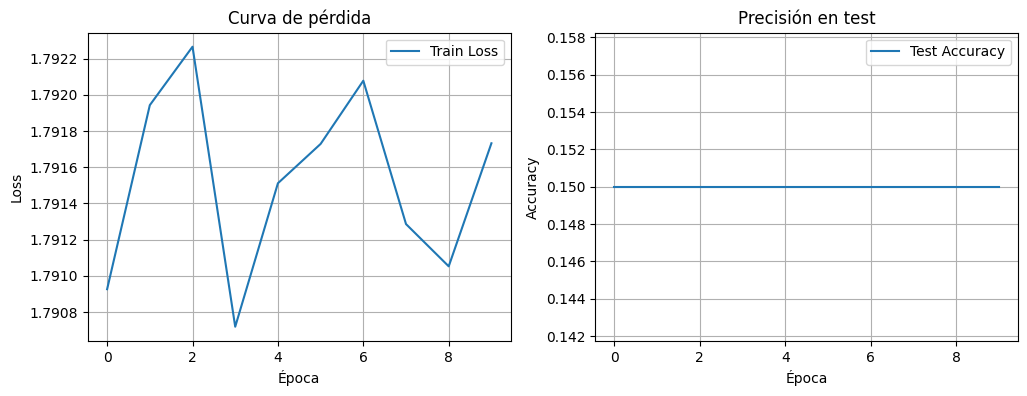

In [11]:
# Pérdida y precisión
plt.figure(figsize=(12,4))

plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label="Train Loss")
plt.title("Curva de pérdida")
plt.xlabel("Época")
plt.ylabel("Loss")
plt.grid()
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(test_acc_history, label="Test Accuracy")
plt.title("Precisión en test")
plt.xlabel("Época")
plt.ylabel("Accuracy")
plt.grid()
plt.legend()

plt.show()


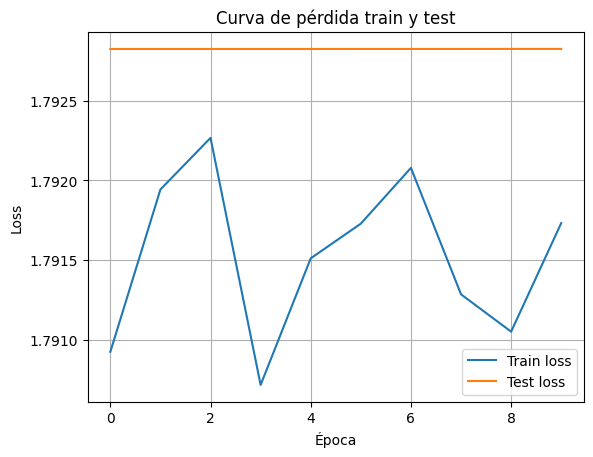

In [12]:
plt.title("Curva de pérdida train y test")
plt.plot(train_loss_history, label="Train loss")
plt.plot(test_loss_history, label="Test loss")
plt.xlabel("Época")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()

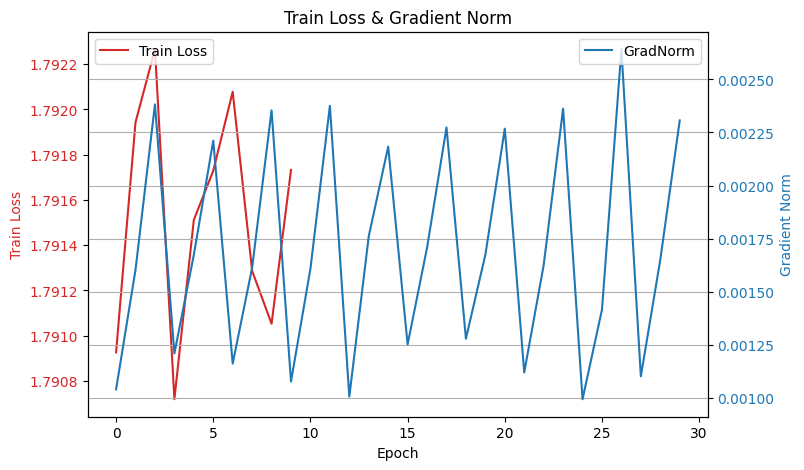

In [13]:
fig, ax1 = plt.subplots(figsize=(8, 5))

color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Train Loss', color=color)
ax1.plot(train_loss_history, color=color, label="Train Loss")
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Gradient Norm', color=color)
ax2.plot(gradient_history, color=color, label="GradNorm")
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(loc='upper right')

plt.title("Train Loss & Gradient Norm")
plt.grid(True)
plt.show()

Explorar cómo varía la pérdida (loss) de un modelo cuando modificas sus parámetros a lo largo de una dirección concreta. Esto permite visualizar cómo "accidentado" o plano es el paisaje de optimización.

-model: el circuito cuántico.

-base_params: los parámetros actuales del modelo ya entrenado.

-direction: una dirección aleatoria o definida en el espacio de parámetros (misma dimensión que base_params).

-alpha_range: define el rango de valores de $\alpha$ (entre -1 y 1). Como cambia el loss cuando se dirige a esa dirección

-steps: número de valores de α para recorrer esa dirección.

Permite ver cómo se comporta la función de pérdida en torno a una solución dada (base_params) cuando se perturba ligeramente. Si la loss apenas cambia → meseta estéril.


In [14]:
def loss_landscape_1d(model, base_params, direction, alpha_range=(-1, 1), steps=50):
    #α ∈ [−1, 1] con steps pasos. Se explora cómo cambia el modelo cuando se perturba en esa dirección. 
    alphas = np.linspace(*alpha_range, steps)
    losses = []

    for alpha in alphas:
    # Se está generando un nuevo punto: 𝜃_perturbed=𝜃_base+𝛼⋅𝑑 

        perturbed_params = [p + alpha * d for p, d in zip(base_params, direction)]
        with torch.no_grad(): #No vamos a hacer backprop solo calcular el loss
            # Aplicar estos parámetros temporalmente al modelo
            idx = 0
            for param in model.parameters():
                param.data = perturbed_params[idx] #No afecta al grafo, modificación in-place, por fuera del grafo, fuera del sistema autodiff
                idx += 1
            output = model(X_train)
            #Calculamos la perdida sin backpropagation
            loss = nn.CrossEntropyLoss()(output, y_train)
            losses.append(loss.item())
    
    return alphas, losses #los valores recorridos de alpha y las correspondientes pérdidas


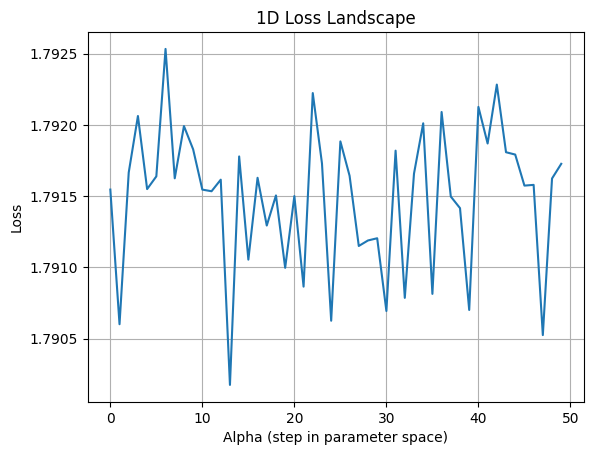

In [15]:
# Guardar los pesos finales
final_params = [p.clone().detach() for p in model.parameters()]
# Usar una dirección aleatoria (simulando un pequeño cambio)
direction = [torch.randn_like(p) for p in model.parameters()]

alphas, losses = loss_landscape_1d(model, final_params, direction)


plt.plot(losses)
plt.title("1D Loss Landscape")
plt.xlabel("Alpha (step in parameter space)")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

Aquí vemos un paisaje de pérdida 1D donde nos movemos en una dirección aleatoria del espacio de parámetros. 

Lo interesante es que, aunque hay algo de ruido, el valor de la pérdida se mantiene prácticamente constante. Esto es una señal clara de que estamos en una ‘meseta estéril’, donde los gradientes son cercanos a cero y el optimizador no puede aprender nada útil

In [22]:
def plot_gradient_landscape(model, input_sample, true_label, param_index1=(0,0), param_index2=(0,1), steps=50):
    theta1 = np.linspace(0, 2*np.pi, steps)
    theta2 = np.linspace(0, 2*np.pi, steps)
    Theta1, Theta2 = np.meshgrid(theta1, theta2)
    Z = np.zeros_like(Theta1)

    with torch.no_grad():
        #original_weights = model.q_layers[0].weight.clone().detach()
        original_weights = model.qmodel.weights

    for i in range(steps):
        for j in range(steps):
            w = original_weights.clone()
            w[param_index1] = theta1[i]
            w[param_index2] = theta2[j]

            w = w.clone().detach().requires_grad_(True)
            model.qmodel.weights = nn.Parameter(w)

            output = model(input_sample)#.unsqueeze(0))
            loss = nn.CrossEntropyLoss()(output, true_label)#.unsqueeze(0))
            loss.backward()

            # Calculamos la norma del gradiente
            grads = []
            for param in model.parameters():
                if param.grad is not None:
                    grads.append(param.grad.abs().mean().item())
            grad_norm = sum(grads) / len(grads) if grads else 0
            Z[j, i] = grad_norm

            model.zero_grad()

    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(Theta1, Theta2, Z, cmap='plasma')
    #ax.plot_surface(Theta1, Theta2, Z, cmap='viridis')
    ax.set_xlabel('θ₁')
    ax.set_ylabel('θ₂')
    ax.set_zlabel('Grad Norm')
    ax.set_title('Gradient Landscape')
    plt.tight_layout()
    plt.show()

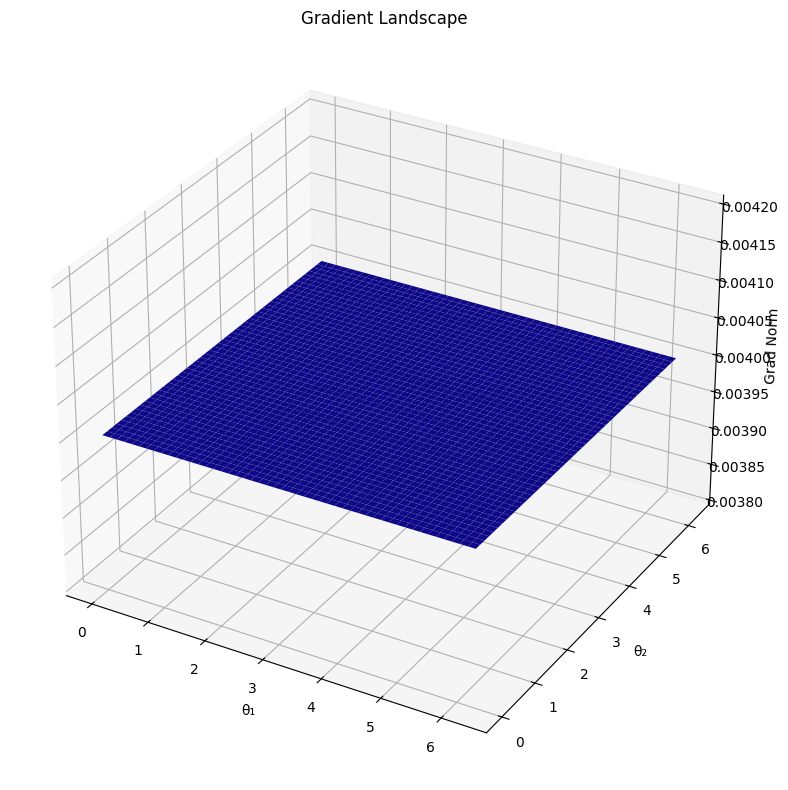

In [23]:
input_sample=X_train[:10]
true_label= y_train[:10]
plot_gradient_landscape(model, input_sample, true_label, param_index1=(0,0), param_index2=(0,1), steps=50)

- En casi todo el espacio de parámetros $( \theta_1, \theta_2)$, la norma del gradiente es bajísima (lo que ves como un plano morado muy pegado al eje $z=0$).
- Solo en un filito ultraestrecho (la línea amarilla) hay un cambio apreciable $\rightarrow$ indica un "cliff" o "borde" muy afilado, pero que es tan pequeño que es casi imposible de encontrar al azar.

Es decir, el gradiente esperado tiende a cero, esto significa que el optimizador no tiene información útil para actualizar los parámetros $\rightarrow$ se queda "atrapado" en una llanura plana (meseta).

In [38]:
W= torch.distributions.uniform.Uniform(low=0.0, high=np.pi/2).sample([num_layers, num_qubits, 4]).detach().clone().requires_grad_(True)
Wi= torch.distributions.uniform.Uniform(low=0.0, high=1).sample([num_layers, num_qubits, 1]).detach().clone().requires_grad_(True)
print(qml.draw(circuit.qnode, show_all_wires=True)(weightsin=Wi, weights=W, inputs=[1,0,1,0,1,1,1,1,0,0,0,0,0,0,1]))

 0: ──RY(0.49)──RX(1.53)──RY(0.04)──RZ(1.44)─╭●────────╭●────────╭●────────╭●────────╭●─────── ···
 1: ──RY(0.00)──RX(1.54)──RY(0.38)──RZ(0.19)─╰RY(0.27)─│─────────│─────────│─────────│──────── ···
 2: ──RY(0.28)──RX(0.80)──RY(0.65)──RZ(0.59)───────────╰RY(0.27)─│─────────│─────────│──────── ···
 3: ──RY(0.00)──RX(1.50)──RY(0.07)──RZ(1.30)─────────────────────╰RY(0.27)─│─────────│──────── ···
 4: ──RY(0.50)──RX(0.19)──RY(0.14)──RZ(0.43)───────────────────────────────╰RY(0.27)─│──────── ···
 5: ──RY(0.37)──RX(1.12)──RY(1.08)──RZ(1.13)─────────────────────────────────────────╰RY(0.27) ···
 6: ──RY(0.96)──RX(0.81)──RY(0.73)──RZ(0.28)────────────────────────────────────────────────── ···
 7: ──RY(0.05)──RX(0.56)──RY(1.42)──RZ(0.99)────────────────────────────────────────────────── ···
 8: ──RY(0.00)──RX(1.54)──RY(0.49)──RZ(0.01)────────────────────────────────────────────────── ···
 9: ──RY(0.00)──RX(0.93)──RY(0.88)──RZ(1.56)────────────────────────────────────────────────── ···
10: ──RY(0

In [41]:
model

VQC(
  (qmodel): <Quantum Torch Layer: func=circuit>
)